In [1]:
!nvidia-smi

Wed May  8 07:45:32 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
#How many images in each folder?
import os

for dirpath, dirnames, filenames in os.walk("/content/drive/MyDrive/CDD-CESM_two_datas"):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_two_datas'.
There are 3 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Test'.
There are 0 directories and 144 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Test/Malignant'.
There are 0 directories and 107 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Test/Benign'.
There are 0 directories and 292 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Test/Normal'.
There are 3 directories and 0 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Train'.
There are 0 directories and 1237 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Train/Normal'.
There are 0 directories and 568 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Train/Benign'.
There are 0 directories and 796 images in '/content/drive/MyDrive/CDD-CESM_two_datas/Train/Malignant'.


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "/content/drive/MyDrive/CDD-CESM_two_datas/Train"
test_dir = "/content/drive/MyDrive/CDD-CESM_two_datas/Test/"

train_datagen = ImageDataGenerator(rescale=1/255.)
test_datagen = ImageDataGenerator(rescale=1/255.)

print("Training images:")
train_data_cancer = train_datagen.flow_from_directory(train_dir,
                                               target_size=IMAGE_SHAPE,
                                               batch_size=BATCH_SIZE,
                                               class_mode="categorical")

print("Testing images:")
test_data_cancer = test_datagen.flow_from_directory(test_dir,
                                              target_size=IMAGE_SHAPE,
                                              batch_size=BATCH_SIZE,
                                              class_mode="categorical")

Training images:
Found 2601 images belonging to 3 classes.
Testing images:
Found 543 images belonging to 3 classes.


In [4]:
#Create TensorBoard callback (functionized because we need to create a new one for each model)
import datetime

def create_tensorboard_callback(dir_name,experiment_name):
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

In [5]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"

efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [6]:
#import depencencies
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [7]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [8]:
#let's make a create_model() function to create a model from a URL
def create_model(model_url,num_classes=2):
  """
  Takes a Tensorflow Hub URL and creates a Keras Sequential model with it.

  Args:
    model_url (str): A Tensorflow Hub feature extraction URL.
    num_classes (int): Number of output neurons in the output layer,
      should be equal to the number of target classes, default 10.

  Returns:
    An uncompiled Keras Sequential model with model_url as feature
    extractor layer and Dense output layer with num_classes outputs.
  """
  # Download the pretrained model and save it as a Keras Layer
  feature_extractor_layer = hub.KerasLayer(model_url,
                                           trainable=False, # freeze the already learned patterns
                                           name='feature_extraction_layer',
                                           input_shape=IMAGE_SHAPE+(3,)) # define the input image shape

  #Create our own model
  model = tf.keras.Sequential([
    feature_extractor_layer,
    layers.Dense(num_classes, activation='softmax',name ="output_layer")
  ])
  return model


In [9]:
resnet_model = create_model(resnet_url, train_data_cancer.num_classes)

In [10]:
#compile our resnet model
resnet_model.compile(loss="binary_crossentropy",
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=["accuracy"])

In [11]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 feature_extraction_layer (  (None, 2048)              23564800  
 KerasLayer)                                                     
                                                                 
 output_layer (Dense)        (None, 3)                 6147      
                                                                 
Total params: 23570947 (89.92 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 23564800 (89.89 MB)
_________________________________________________________________


In [12]:
print(train_data_cancer.labels.shape)
print(test_data_cancer.labels.shape)

(2601,)
(543,)


In [ ]:
#Let's fit our ResNet model to the data
resnet_history = resnet_model.fit(train_data_cancer,
                                  epochs=50,
                                  steps_per_epoch=len(train_data_cancer),
                                  validation_data=test_data_cancer,
                                  validation_steps=len(test_data_cancer),
                                  callbacks=[create_tensorboard_callback(dir_name="tensorflow_hub",
                                                                         experiment_name="resnet50V2")])

Saving TensorBoard log files to: tensorflow_hub/resnet50V2/20240507-105034
Epoch 1/50
67/82 [=======================>......] - ETA: 6:28 - loss: 0.6114 - accuracy: 0.5205

In [13]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

#Create data augmentation stage with horizontal flipping,rotations,zoom, etc
data_augmentation = keras.Sequential([
  preprocessing.RandomFlip("horizontal"),
  preprocessing.RandomRotation(0.2),
  preprocessing.RandomZoom(0.2),
  preprocessing.RandomWidth(0.2),
  preprocessing.RandomHeight(0.2),
  #preprocessing.Rescale(1.0/255)
], name="data_augmentation")

In [14]:
train_data_cancer.class_indices

{'Benign': 0, 'Malignant': 1, 'Normal': 2}

/content/drive/MyDrive/CDD-CESM_two_datas/Train/Malignant/P275_L_DM_CC.jpg


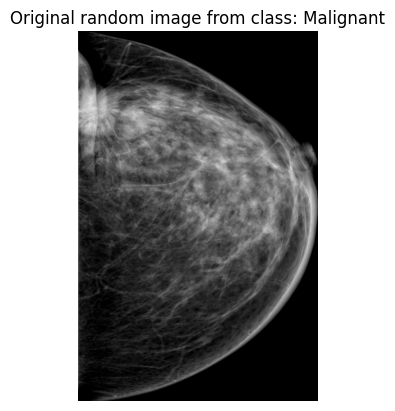

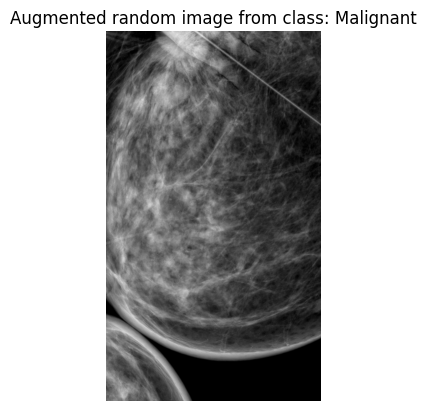

In [15]:
# view a random image and compare it to its augmented version.
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import random
target_class = random.choice(list(train_data_cancer.class_indices.keys()))
target_dir = "/content/drive/MyDrive/CDD-CESM_two_datas/Train/" + target_class
random_image = random.choice(os.listdir(target_dir))
random_image_path = target_dir + "/" + random_image
print(random_image_path)
img = mpimg.imread(random_image_path)
plt.imshow(img)
plt.title(f"Original random image from class: {target_class}")
plt.axis("off");

augmented_img = data_augmentation(tf.expand_dims(img, axis=0))
plt.figure()
plt.imshow(tf.squeeze(augmented_img)/255.)
plt.title(f"Augmented random image from class: {target_class}")
plt.axis("off");

In [21]:
IMG_SIZE = (224,224)

input_shape = (224,224,3)
IMG_SIZE + (3,)
base_model = keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False

#Create input layer
inputs = layers.Input(shape=input_shape, name="input_layer")

#Add in data augmentation Sequential model as a layer
x = data_augmentation(inputs)

#Give base_model inputs (after augmentation) and don't train it
x = base_model(x, training=False)

#Average pool the outputs of the base model (aggregate all the most important information, reduce number of computations)
x = layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

#Put a dense layer on as the output
outputs = layers.Dense(3, activation="softmax", name="output_layer")(x)

#Make a model with inputs and outputs
model_1 = keras.Model(inputs, outputs)

#Compile the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [22]:
#Fit the model
history_1 = model_1.fit(train_data_cancer,
                        epochs=50,
                        steps_per_epoch=len(train_data_cancer),
                        validation_data=test_data_cancer,
                        validation_steps=int(0.25 * len(test_data_cancer)),
                        callbacks=[create_tensorboard_callback(dir_name="transfer_learning",
                                                                experiment_name="efficientnetb0_1_percent_data_aug")])

Saving TensorBoard log files to: transfer_learning/efficientnetb0_1_percent_data_aug/20240508-080801
Epoch 1/50
82/82 [==============================] - 117s 1s/step - loss: 1.0569 - accuracy: 0.4725 - val_loss: 1.0665 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 99s 1s/step - loss: 1.0599 - accuracy: 0.4641 - val_loss: 0.9890 - val_accuracy: 0.5781
Epoch 3/50
82/82 [==============================] - 91s 1s/step - loss: 1.0590 - accuracy: 0.4756 - val_loss: 1.0399 - val_accuracy: 0.5547
Epoch 4/50
82/82 [==============================] - 86s 1s/step - loss: 1.0572 - accuracy: 0.4702 - val_loss: 1.0440 - val_accuracy: 0.5156
Epoch 5/50
82/82 [==============================] - 82s 995ms/step - loss: 1.0579 - accuracy: 0.4710 - val_loss: 1.0719 - val_accuracy: 0.4688
Epoch 6/50
82/82 [==============================] - 79s 962ms/step - loss: 1.0604 - accuracy: 0.4587 - val_loss: 1.0505 - val_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 

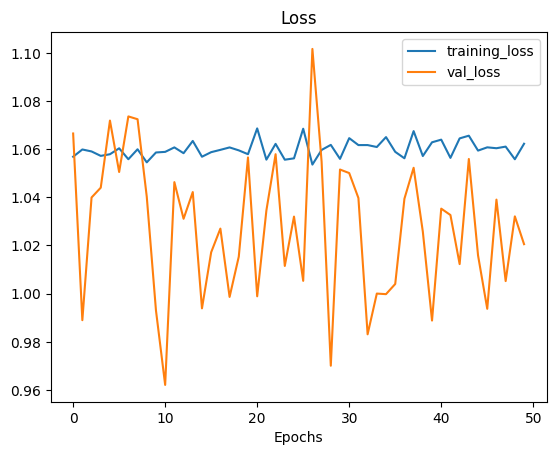

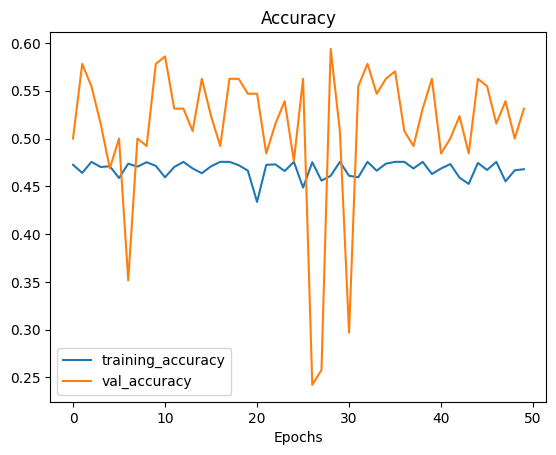

In [24]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow History object.

    Returns:
    Plots of training/validation loss and accuracy metrics.
  """
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  #Plot loss

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  #Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_1)

In [25]:
from sklearn.metrics import confusion_matrix

y_true = test_data_cancer.labels
y_pred = resnet_model.predict(test_data_cancer)
y_pred_binary = [int(round(p[0])) for p in y_pred]

confusion_matrix = confusion_matrix(y_true, y_pred_binary)

print(confusion_matrix)

17/17 [==============================] - 20s 995ms/step
[[103   4   0]
 [136   8   0]
 [278  14   0]]


In [26]:

from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred_binary)

print(report)


              precision    recall  f1-score   support

           0       0.20      0.96      0.33       107
           1       0.31      0.06      0.09       144
           2       0.00      0.00      0.00       292

    accuracy                           0.20       543
   macro avg       0.17      0.34      0.14       543
weighted avg       0.12      0.20      0.09       543



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
